In [1]:
import operator
import pandas as pd
from zipfile import ZipFile 
from os import listdir
import pandas as pd
import time
from collections import defaultdict
import operator
from collections import Counter
import string
import numpy as np
import sys
import pandas as pd
from scipy.stats import pearsonr 
import pylab 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from gensim.models.keyedvectors import KeyedVectors
import nltk
from nltk.corpus import stopwords
from numpy import dot
from numpy.linalg import norm
import sklearn.metrics.pairwise
from statistics import mean, stdev
import json
import networkx as nx
import community
import math

def flushPrint(d): # counter
    sys.stdout.write('\r')
    sys.stdout.write(str(d))
    sys.stdout.flush()

## Prepare Data

### Occupation name, demand, pay, pay change, required education

In [2]:
# Occupation name, demand, pay, education level
yjn = defaultdict(lambda:defaultdict(lambda:0))
yje = defaultdict(lambda:defaultdict(lambda:0))
yjp = defaultdict(lambda:defaultdict(lambda:0))
jyn = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
jyp = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/occ_year_freq_edu_pay.txt','r') as f:
    for line in f:
        line_lst = line.split('\t')
        job = line_lst[0]
        year = int(line_lst[1])
        num = line_lst[2]
        edu = line_lst[3]
        pay = line_lst[4]
        if year != 2019:
            yjn[year][job] = int(num) 
            jyn[job][year] = int(num)
            if edu != 'nan' and edu != 'nan\n': 
                med_edu = edu.split('_')[1]
                if med_edu != 'nan' and float(med_edu) > 0:
                    yje[year][job] = float(med_edu)
                    jye[job][year] = float(med_edu)
            if pay != 'nan' and pay != 'nan\n':
                med_pay = pay.split('_')[1]
                if med_pay != 'nan' and float(med_pay) > 0:
                    yjp[year][job] = float(med_pay)
                    jyp[job][year] = float(med_pay)

In [3]:
# get annual average number for demand, pay, education for each occupation
on = defaultdict(lambda:0)
oe = defaultdict(lambda:0)
op = defaultdict(lambda:0)
for job in jyn:
    on[job] = int(mean(jyn[job].values()))
for job in jye:
    oe[job] = mean(jye[job].values())
for job in jyp:
    op[job] = mean(jyp[job].values())

In [4]:
# calculate the average annual pay change of occupations from each year
opagr = {}
for job in jyp:
    sum_cr = 0
    n=0
    for yr in range(2010, 2018):
        if yr in jyp[job] and (yr+1) in jyp[job]:
            n+=1
            sum_cr = sum_cr + (jyp[job][yr+1] - jyp[job][yr]) / jyp[job][yr]
    if n > 0:
        opagr[job] = sum_cr / n 

s_opagr = dict(sorted(opagr.items(), key=operator.itemgetter(1),reverse=True))

In [5]:
# calculate the average annual demand change of occupations from each year
onagr = {}
for job in jyn:
    sum_cr = 0
    n=0
    for yr in range(2010, 2018):
        if yr in jyn[job] and (yr+1) in jyn[job]:
            n+=1
            sum_cr = sum_cr + (jyn[job][yr+1] - jyn[job][yr]) / jyn[job][yr]
    if n > 0:
        onagr[job] = sum_cr / n 

s_odagr = dict(sorted(onagr.items(), key=operator.itemgetter(1),reverse=True))

### skill and skill number change

In [7]:
# without filtering the skills, skill-tfidf 
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/occ_skill_tfidf.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0]
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf

In [8]:
# filter the defining skills with above mean tf-idf
yjsn = defaultdict(lambda:defaultdict(lambda:0))
yjs = defaultdict(lambda:defaultdict(lambda:set()))
jys = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for year in yjas:
    for job in yjas[year]:
        threshold = mean(yjas[year][job].values())
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                yjs[year][job] = yjs[year][job] | set([skill])
                jys[job][year][skill] = yjas[year][job][skill]
        if len(yjs[year][job]) < 5:
            del yjs[year][job]
            del jys[job][year]
        else:
            yjsn[year][job] = len(yjs[year][job])

In [9]:
# calculate the average annual skill number change of occupations from each year
osnagr = {}
osn = {}
for job in jys:
    osn[job] = mean([len(m) for m in jys[job].values()])
    sum_cr = 0
    n=0
    for i in range(2010, 2019):
        if i in jys[job] and (i+1) in jys[job]:
            n+=1
            sum_cr = sum_cr + (len(jys[job][i+1]) - len(jys[job][i])) / len(jys[job][i])
    if n > 0:
        osnagr[job] = sum_cr / n 

s_osnagr = dict(sorted(osnagr.items(), key=operator.itemgetter(1),reverse=True))
s_osn = dict(sorted(osn.items(), key=operator.itemgetter(1),reverse=True))

### Skill RCA data

In [10]:
# read in the rca score for each skill for each occupation
syorca = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
syopmi = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/occ_skill_rca.txt', 'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        occ = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        for s_rca in skills:
            skill = s_rca.split('_')[0].lower()
            rca = float(s_rca.split('_')[1])
            syorca[skill][year][occ] = rca
            syopmi[skill][year][occ] = math.log(rca)

### 2010 Skills Co-occurence Network

In [87]:
with open('/Users/ditong/Documents/skillProject/description/data/graph_dict.json','r')as f:
    graph_dict = json.load(f)
graph_dict = {(int(i.split(',')[0]),int(i.split(',')[-1])): graph_dict[i] for i in graph_dict}

with open('/Users/ditong/Documents/skillProject/description/data/2010_skills_index_dict.json','r')as f:
    name_dict = json.load(f)
name_index = {name_dict[i]:int(i) for i in name_dict}
name_dict = {int(i):name_dict[i] for i in name_dict.keys()}

BG = nx.Graph()
for pair in graph_dict:
    BG.add_edge(*pair,weight = graph_dict[pair])

### Industry, Career Area

In [11]:
# industry data
ijyn = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/industry_occ_year_freq_edu_pay.txt','r') as f:
    for line in f:
        if line != '\n':
            line_lst = line[:-1].split('\t')
            ind = line_lst[0]
            job = line_lst[1]
            year = int(line_lst[2])
            num = int(line_lst[3])
            if year != 2019:
                ijyn[ind][job][year] = num

ijn = defaultdict(lambda:defaultdict(lambda:0))
for ind in ijyn:
    for job in ijyn[ind]:
        ijn[ind][job] = mean(ijyn[ind][job].values())

In [12]:
#Career Area data
cajyn = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/CarArea_occ_year_freq_edu_pay.txt','r') as f:
    for line in f:
        if line != '\n':
            line_lst = line[:-1].split('\t')
            cararea = line_lst[0]
            job = line_lst[1]
            year = int(line_lst[2])
            num = int(line_lst[3])
            cajyn[cararea][job][year] = num

cajn = defaultdict(lambda:defaultdict(lambda:0))
for cararea in cajyn:
    for job in cajyn[cararea]:
        cajn[cararea][job] = mean(cajyn[cararea][job].values())

In [11]:
# BLS occupation codes
df_2018=pd.read_excel('/Users/ditong/Documents/skillProject/description/data/SOC/BLS/national_M2018_dl.xlsx')
ocg={}
cg = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['OCC_GROUP'], df_2018['OCC_CODE']):
    if j=='major':
        cg[k[:2]] = i
    elif j == 'detailed':
        ocg[i] = cg[k[:2]]

go = defaultdict(lambda:set())
for occ in ocg:
    go[ocg[occ]].add(occ)
    
gon = defaultdict(lambda:defaultdict(lambda:0))
for g in go:
    for o in go[g]:
        if o in on:
            gon[g][o] = on[o]

### computerization score data

In [12]:
CR={}#computerization risk by Frey #https://www.oxfordmartin.ox.ac.uk/publications/the-future-of-employment/
n=0
with open('/Users/ditong/Documents/skillProject/description/data/rank_probability_label_soc_occupation.txt','r', encoding="utf-8") as f:
    for line in f:
        rank,pro,label,jobcode,jobname=line.strip().split('\t')
        if pro:
            #CR[jobname]=int(label)
            CR[jobname]=float(pro)

### Regional data

In [14]:
# voting data
df_vote = pd.read_csv('/Users/ditong/Documents/skillProject/description/data/2016_vote.csv')

In [142]:
# state
dic_state_job_num = defaultdict(lambda:defaultdict(lambda:0))
dic_year_state_job_num = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for i in range(2010, 2020):
    year = str(i)
    with open('/Users/ditong/Documents/skillProject/description/data/SOC/' + year + '/' + 
              year + '_state_job_freq_edu_pay.txt','r') as f:
        for line in f:
            if line != '\n':
                line_lst = line[:-1].split('\t')
                state = line_lst[0]
                job = line_lst[1]
                num = int(line_lst[2])
                if state in list(df_vote['State']) and job in CR:
                    dic_year_state_job_num[year][state][job] = num
                    dic_state_job_num[state][job] += num

In [144]:
# city and location
dic_state_city_year_job_num = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0))))
dic_loc_year_job_num = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
dic_state_city_job_num = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
dic_loc_job_num = defaultdict(lambda:defaultdict(lambda:0))
dic_loc_year_job_pay = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for i in range(2010, 2020):
    year = str(i)
    with open('/Users/ditong/Documents/skillProject/description/data/SOC/' + year + '/' + 
              year + '_state_city_loc_job_freq_edu_pay.txt','r') as f:
        for line in f:
            if line != '\n':
                line_lst = line[:-1].split('\t')
                state = line_lst[0]
                city = line_lst[1]
                lat, lon = line_lst[2].split('_')
                loc = (lat, lon)
                job = line_lst[3]
                num = int(line_lst[4])
                paystr = line_lst[6]
                if job in CR:
                    dic_state_city_year_job_num[state][city][year][job] += num
                    dic_loc_year_job_num[loc][year][job] += num
                    dic_state_city_job_num[state][city][job] += num
                    dic_loc_job_num[loc][job] += num
                    if paystr != 'nan':
                        paylst = paystr.split("_")
                        if paylst[1] != 'nan':
                            dic_loc_year_job_pay[loc][year][job] = float(paylst[1])

### Pretrained Google News Word2vec Model

In [127]:
# Read in the pre-trained Google News word2vec model 
model = KeyedVectors.load_word2vec_format(
    '/Users/ditong/Documents/skillProject/description/data/GoogleNews-vectors-negative300.bin', 
    binary=True)

## Description

In [13]:
def get_statistics(dic, label, df, calculate_sum=False, occ=False):
        
    num_lst = []
    SD_lst =[]
    comb_lst = []
    sum_lst = []
    for year in range(2010, 2019):
        if occ == True:
            num_lst.append(len(dic[year]))
        else:
            mean_ = round(mean(float(value) for value in dic[year].values()),2)
            std_ = round(stdev(float(value) for value in dic[year].values()),2)
            num_lst.append(mean_)
            SD_lst.append(std_)
            comb_lst+=[str(mean_) + ' (' + str(std_) + ')' ]
        sum_lst.append(sum(float(value) for value in dic[year].values()))
        
    df[label] = num_lst
    
    if occ == True:
        mean_num = max(num_lst)
    else:
        mean_num = mean(num_lst)
        df[label+'(SD)'] = comb_lst
    
    if calculate_sum == True:
        sum_num = sum(sum_lst)
        df['total_post'] = sum_lst
        return sum_num, mean_num
    else:
        return mean_num  

In [14]:
df_year_jobs = pd.DataFrame()
df_year_jobs['year'] = list(range(2010, 2019))

total_skill = []
for year in range(2010, 2019):
    skills = set()
    for job in yjs[year]:
        for skill in yjs[year][job]:
            skills.add(skill)
    total_skill.append(len(skills))
    
mean_occ = get_statistics(yjn, 'occupation', df_year_jobs, calculate_sum=False, occ=True)
sum_post, mean_post = get_statistics(yjn, 'post_per_occ', df_year_jobs, calculate_sum=True, occ=False)
mean_skill = get_statistics(yjsn, 'skill_per_occ', df_year_jobs, calculate_sum=False, occ=False)
df_year_jobs['total_skill'] = total_skill
mean_pay = get_statistics(yjp, 'pay_per_occ', df_year_jobs, calculate_sum=False, occ=False)
mean_edu = get_statistics(yje, 'edu_per_occ', df_year_jobs, calculate_sum=False, occ=False)
df_year_jobs= df_year_jobs.set_index(['year'])

In [22]:
# print average and sum (without 2019 data)
print("The total number of job posts is ", round(sum_post))
print("The average number of posts per occupation is ", round(mean_post))
print("The average number of skill per occupation is ", round(mean_skill))
print("The average median pay of occupation is ", round(mean_pay))
print("The average median required education level of occupation is ", round(mean_edu))

The total number of job posts is  167853293
The average number of posts per occupation is  22410
The average number of skill per occupation is  238
The average median pay of occupation is  53627
The average median required education level of occupation is  15


In [16]:
df_year_jobs

,occupation,post_per_occ,post_per_occ(SD),total_post,skill_per_occ,skill_per_occ(SD),total_skill,pay_per_occ,pay_per_occ(SD),edu_per_occ,edu_per_occ(SD)
year,,,,,,,,,,,
2010,829,13759.83,13759.83 (42464.2),11406899.0,193.52,193.52 (228.78),10296,54151.46,54151.46 (27793.82),14.97,14.97 (2.16)
2011,831,16661.87,16661.87 (51376.43),13846016.0,226.11,226.11 (254.35),10758,52031.69,52031.69 (23860.31),14.93,14.93 (2.16)
2012,831,16524.32,16524.32 (49234.34),13731712.0,230.14,230.14 (253.99),10915,55429.42,55429.42 (28030.6),14.87,14.87 (2.18)
2013,833,21060.31,21060.31 (61225.94),17543235.0,234.97,234.97 (258.97),11086,52271.91,52271.91 (22637.45),14.88,14.88 (2.16)
2014,833,22211.49,22211.49 (66172.61),18502175.0,238.69,238.69 (265.02),11079,52818.13,52818.13 (23349.56),14.86,14.86 (2.14)
2015,833,24370.69,24370.69 (78582.65),20300784.0,253.63,253.63 (277.97),11299,53817.52,53817.52 (23482.28),14.86,14.86 (2.13)
2016,832,27500.70,27500.7 (99589.23),22880585.0,243.82,243.82 (269.31),11154,53817.81,53817.81 (24816.25),14.84,14.84 (2.13)
2017,834,26003.25,26003.25 (92381.7),21686711.0,247.13,247.13 (269.18),11115,54169.20,54169.2 (23210.08),14.82,14.82 (2.15)
2018,832,33599.97,33599.97 (104220.75),27955176.0,270.46,270.46 (286.32),11379,54133.12,54133.12 (23020.63),14.72,14.72 (2.18)


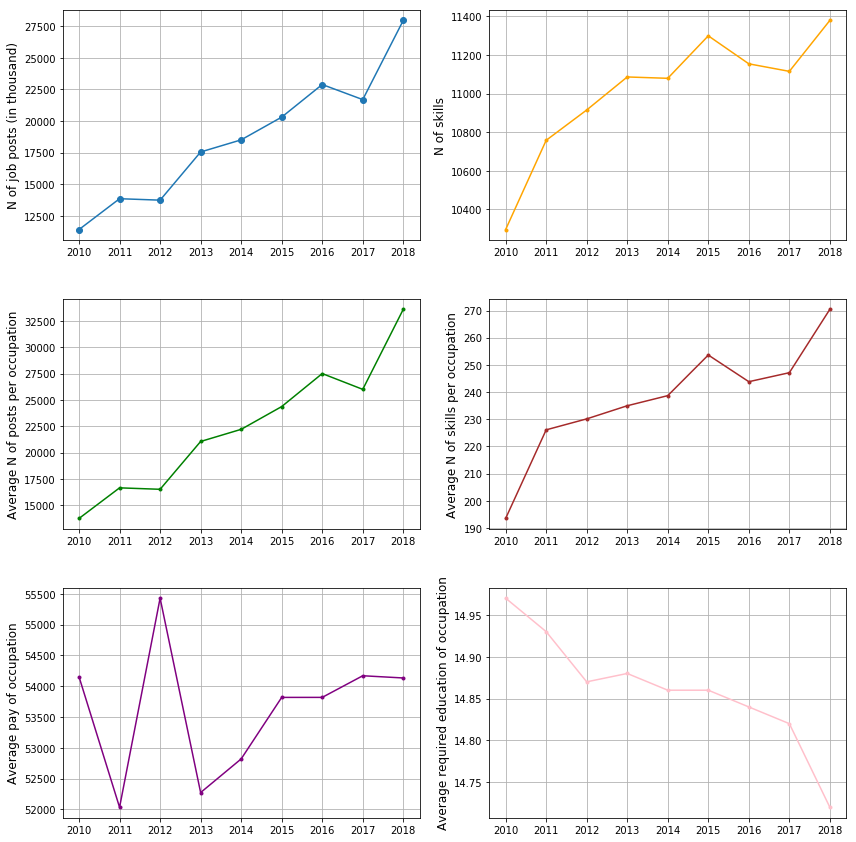

In [17]:
# temporal change graphs
fig = plt.figure(figsize=(12, 12),facecolor='white')

# plot jobs by year
ax = fig.add_subplot(321)
plt.plot(df_year_jobs.index, [num/1000 for num in df_year_jobs['total_post']], 'o-')
plt.ylabel('N of job posts (in thousand)', fontsize=12)
plt.grid()

# plot skills by year
ax = fig.add_subplot(322)
plt.plot(df_year_jobs.index, df_year_jobs['total_skill'], '.-', c='orange')
#plt.xticks(range(lists[0][0], lists[-1][0], 10))
plt.ylabel('N of skills', fontsize=12)
plt.grid()

# plot posts by occupation by year
ax = fig.add_subplot(323)
plt.plot(df_year_jobs.index, df_year_jobs['post_per_occ'], '.-', c='green')
plt.ylabel('Average N of posts per occupation', fontsize=12)
plt.grid()

# plot skills by occupation by year
ax = fig.add_subplot(324)
plt.plot(df_year_jobs.index, df_year_jobs['skill_per_occ'], '.-', c='brown')
plt.ylabel('Average N of skills per occupation', fontsize=12)
plt.grid()

# plot pay per occupation by year
ax = fig.add_subplot(325)
plt.plot(df_year_jobs.index, df_year_jobs['pay_per_occ'], '.-', c='purple')
plt.ylabel('Average pay of occupation', fontsize=12)
plt.grid()

# plot edu per occupation by year
ax = fig.add_subplot(326)
plt.plot(df_year_jobs.index, df_year_jobs['edu_per_occ'], '.-', c='pink')
plt.ylabel('Average required education of occupation', fontsize=12)
plt.grid()

plt.tight_layout()
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/desc.png", bbox_inches='tight')

## What kind of jobs are more susceptible to computerization and automation?

### Required Education Level vs Computerization Risk

In [15]:
jpsnc = defaultdict(lambda:[])
for job in oe:
    jp = np.round(oe[job])
    if job in CR:
        jpsnc[jp].append(CR[job]) 

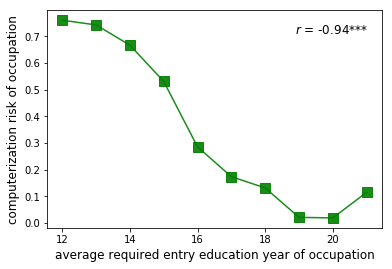

In [17]:
x,y=np.array(sorted([(k,np.mean(v)) for k,v in jpsnc.items()])).T
corr=pearsonr(np.array(x), np.array(y))
if corr[1] < 0.001:
        star = '***'
elif corr[1] >= 0.001 and corr[1] <0.01:
    star = '**'
elif corr[1] >= 0.01 and corr[1] <0.05:
    star = '*'
else:
    star = ''

plt.plot(x,y, marker='s',color='green',markersize=10,alpha=.9)
plt.figtext(0.7, 0.8, r'$r$' + ' = ' + str(round(corr[0], 2)) + star, fontsize=12)     
plt.xlabel('average required entry education year of occupation', fontsize=12)
plt.ylabel('computerization risk of occupation', fontsize=12)    
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/corr_edu_cr.png", bbox_inches='tight')
plt.show()

In [25]:
loc= defaultdict(lambda:defaultdict(lambda:(0,0)))
for job in oe:
    if job in CR:
        x = oe[job]
        y = CR[job]
        loc[job] = (x,y)
X,Y=zip(*loc.values())
corr=pearsonr(X,Y)
corr

(-0.610344146643544, 4.9545929755249026e-70)

### Pay vs Computerization Risk

In [26]:
jpsnc = defaultdict(lambda:[])
for job in op:
    jp = np.round(op[job])
    if job in CR:
        jpsnc[jp].append(CR[job])

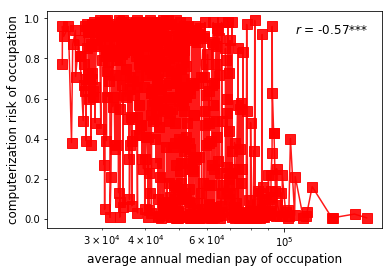

In [28]:
x,y=np.array(sorted([(k,np.mean(v)) for k,v in jpsnc.items()])).T
corr=pearsonr(np.array(x), np.array(y))
if corr[1] < 0.001:
        star = '***'
elif corr[1] >= 0.001 and corr[1] <0.01:
    star = '**'
elif corr[1] >= 0.01 and corr[1] <0.05:
    star = '*'
else:
    star = ''

plt.plot(x,y, marker='s',color='red',markersize=10,alpha=.9)
plt.xscale("log")
plt.figtext(0.7, 0.8, r'$r$' + ' = ' + str(round(corr[0], 2)) + star, fontsize=12)     
plt.xlabel('average annual median pay of occupation', fontsize=12)
plt.ylabel('computerization risk of occupation', fontsize=12)    
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/corr_pay_cr.png", bbox_inches='tight')
plt.show()

In [29]:
loc= defaultdict(lambda:defaultdict(lambda:(0,0)))
for job in op:
    if job in CR:
        x = op[job]
        y = CR[job]
        loc[job] = (x,y)
X,Y=zip(*loc.values())
corr=pearsonr(X,Y)
corr

(-0.5701801270839756, 2.259641068279405e-59)

### Skill Number vs Computerization Risk

In [30]:
snsnc = defaultdict(lambda:[])
for job in osn:
    sn=np.round(osn[job])
    if job in CR:
        snsnc[sn].append(CR[job]) 

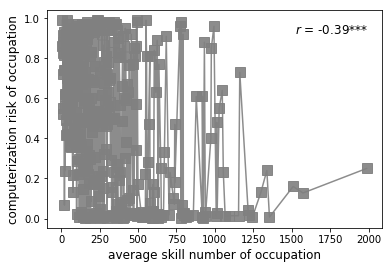

In [31]:
x,y=np.array(sorted([(k,np.mean(v)) for k,v in snsnc.items()])).T
corr=pearsonr(np.array(x), np.array(y))
if corr[1] < 0.001:
        star = '***'
elif corr[1] >= 0.001 and corr[1] <0.01:
    star = '**'
elif corr[1] >= 0.01 and corr[1] <0.05:
    star = '*'
else:
    star = ''

plt.plot(x,y, marker='s',color='grey',markersize=10,alpha=.9)
plt.figtext(0.7, 0.8, r'$r$' + ' = ' + str(round(corr[0], 2)) + '***', fontsize=12)
plt.xlabel('average skill number of occupation', fontsize=12)
plt.ylabel('computerization risk of occupation', fontsize=12)    
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/corr_skillnum_cr.png", bbox_inches='tight')
plt.show()

In [32]:
loc= defaultdict(lambda:defaultdict(lambda:(0,0)))
for job in on:
    if job in CR:
        x = osn[job]
        y = CR[job]
        loc[job] = (x,y)
X,Y=zip(*loc.values())
corr=pearsonr(X,Y)
corr

(-0.32324963553402, 7.392868446937278e-18)

### Computerization risk by industry and career area

In [18]:
def get_ind_score_df(dic_ind_job_num, dic_2, name, year=False):

    ind_score={}
    for ind in dic_ind_job_num:
        jp=defaultdict(lambda:0)
        for job in dic_ind_job_num[ind]:
            if job in dic_2:
                jp[job]+=dic_ind_job_num[ind][job]
        s=sum(jp.values())
        jp=dict((k,v/s) for k,v in jp.items())
        score=sum([jp[i]*dic_2[i] for i in jp])
        ind_score[ind]=score

    sorted_ind_score = sorted(ind_score.items(), key=operator.itemgetter(1),reverse=True)
    df_ind_score = pd.DataFrame(columns = ["industry", name])
    data_ind, data_score = zip(*sorted_ind_score)
    df_ind_score["industry"] = list(data_ind)
    df_ind_score[name] = list(data_score)  
    
    return df_ind_score

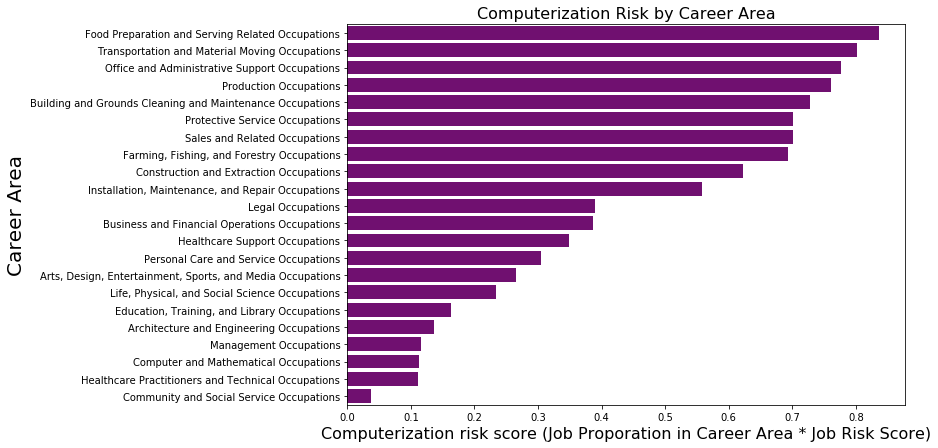

In [20]:
df_ind_sn=get_ind_score_df(gon, CR,'computerization risk')
pylab.figure(figsize=(10,7))
b=sns.barplot(x="computerization risk", y="industry", data=df_ind_sn, color='purple')
b.axes.set_title("Computerization Risk by Career Area",fontsize=16)
b.set_xlabel("Computerization risk score (Job Proporation in Career Area * Job Risk Score)",fontsize=16)
b.set_ylabel("Career Area",fontsize=20)
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/crog.png", bbox_inches='tight')

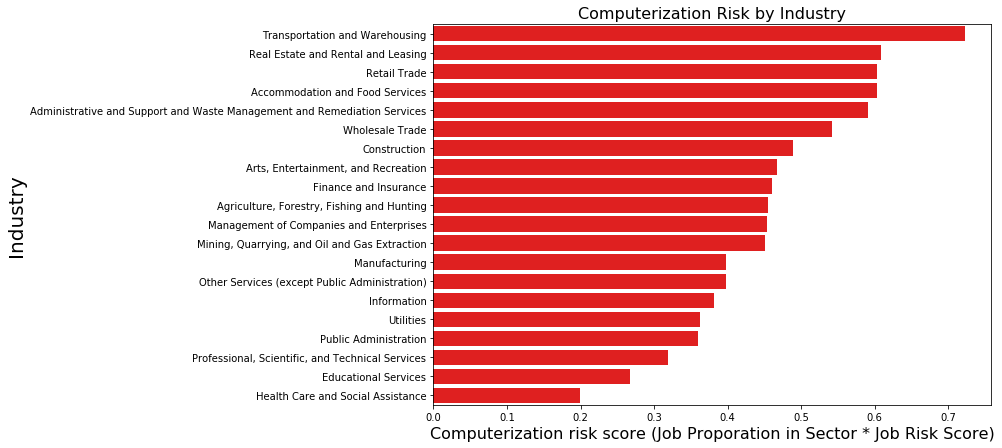

In [35]:
df_ind_sn=get_ind_score_df(ijn, CR,'computerization risk')
pylab.figure(figsize=(10,7))
b=sns.barplot(x="computerization risk", y="industry", data=df_ind_sn, color='red')
b.axes.set_title("Computerization Risk by Industry",fontsize=16)
b.set_xlabel("Computerization risk score (Job Proporation in Industry * Job Risk Score)",fontsize=16)
b.set_ylabel("Industry",fontsize=20)
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/crind.png", bbox_inches='tight')

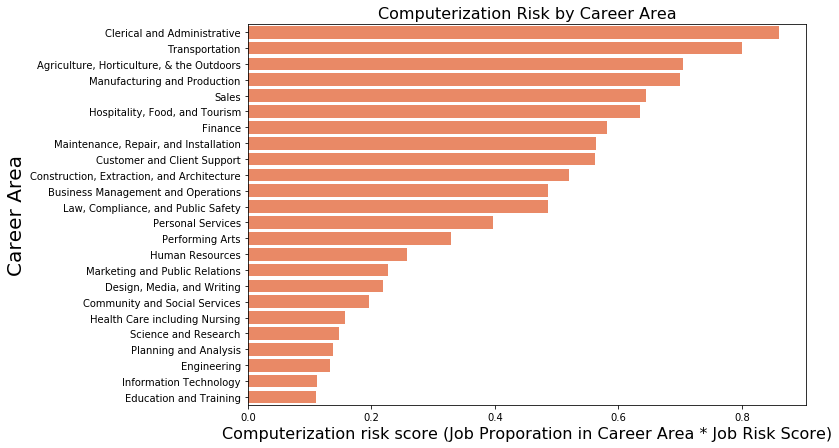

In [36]:
df_ind_sn=get_ind_score_df(cajn, CR,'computerization risk')
pylab.figure(figsize=(10,7))
b=sns.barplot(x="computerization risk", y="industry", data=df_ind_sn, color='coral')
b.axes.set_title("Computerization Risk by Career Area",fontsize=16)
b.set_xlabel("Computerization risk score (Job Proporation in Career Area * Job Risk Score)",fontsize=16)
b.set_ylabel("Career Area",fontsize=20)
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/crca.png", bbox_inches='tight')

### Dimensions

In [191]:
#validation: construct the brain dimension
physical = dimension(model, ['muscle','physical', 'manual', 'body', 'labor', 'handwork'], ['brain', 
                    'intellectual', 'mental', 'mind', 'brainwork', 'headwork'])


# project all skills onto the masculine dimension, store the projection value (cos similarity) in a dictionary gender
df_projections = makeDF(j, list(df_projections.index), df_projections, 'physical', physical)
df_projections = df_projections.sort_values(by=['physical'])

In [192]:
pearsonr(df_projections['risk'],df_projections['physical'])

(0.34918360989761377, 3.938310863364063e-21)

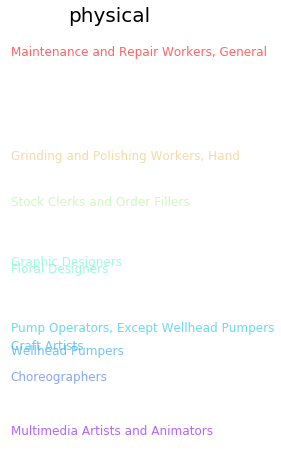

In [202]:
df_physical= pd.DataFrame({})
df_physical['physical'] = df_projections['physical'][:5].append(df_projections['physical'][-5:])
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, df_physical, 'physical')

In [203]:
df_physical

,physical
Multimedia Artists and Animators,-0.062432
Floral Designers,0.054806
Graphic Designers,0.059633
Craft Artists,-0.000640
Choreographers,-0.023320
"Grinding and Polishing Workers, Hand",0.136479
"Maintenance and Repair Workers, General",0.211511
Wellhead Pumpers,-0.004723
"Pump Operators, Except Wellhead Pumpers",0.011844
Stock Clerks and Order Fillers,0.102956


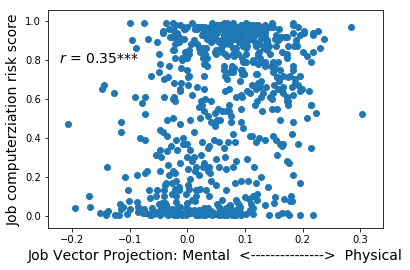

In [204]:
plt.figure(figsize=(6,4))
plt.scatter(df_projections['physical'], df_projections['risk'],)
plt.figtext(0.15, 0.7, r'$r$' + ' = 0.35***',fontsize=14)
plt.xlabel('Job Vector Projection: Mental  <--------------->  Physical', fontsize=14)
plt.ylabel('Job computerziation risk score', fontsize=14)
plt.savefig('/Users/ditong/Documents/skillProject/description/vis/phy_csrisk.png')

In [195]:
#validation: construct the routine dimension
routine = dimension(model, ['routine','common', 'regular', 'usual', 'conventional'], ['creative', 
                    'uncommon', 'irregular', 'unusual', 'innovative'])


# project all skills onto the masculine dimension, store the projection value (cos similarity) in a dictionary gender
df_projections = makeDF(j, list(df_projections.index), df_projections, 'routine', routine)
df_projections = df_projections.sort_values(by=['routine'])

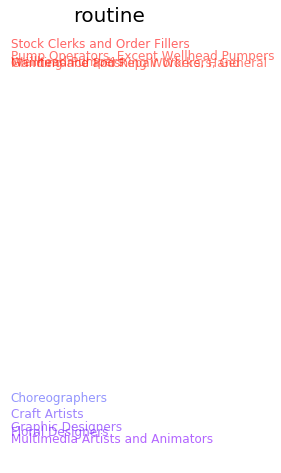

In [200]:
df_routine= pd.DataFrame({})
df_routine['routine'] = df_projections['routine'][:5].append(df_projections['routine'][-5:])
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, df_routine, 'routine')

In [201]:
df_routine

,routine
Multimedia Artists and Animators,-0.272824
Floral Designers,-0.264863
Graphic Designers,-0.260642
Craft Artists,-0.247381
Choreographers,-0.230818
"Grinding and Polishing Workers, Hand",0.110325
"Maintenance and Repair Workers, General",0.110484
Wellhead Pumpers,0.111764
"Pump Operators, Except Wellhead Pumpers",0.117740
Stock Clerks and Order Fillers,0.129823


In [196]:
pearsonr(df_projections['risk'],df_projections['routine'])

(0.34793359667634755, 5.551055462380692e-21)

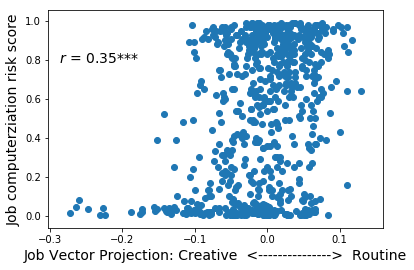

In [205]:
plt.figure(figsize=(6,4))
plt.scatter(df_projections['routine'], df_projections['risk'],)
plt.figtext(0.15, 0.7, r'$r$' + ' = 0.35***',fontsize=14)
plt.xlabel('Job Vector Projection: Creative  <--------------->  Routine', fontsize=14)
plt.ylabel('Job computerziation risk score', fontsize=14)
plt.savefig('/Users/ditong/Documents/skillProject/description/vis/rount_csrisk.png')

## How do the new technologies influence the demand and pay of jobs? 

### computerization risk vs demand change

In [37]:
sncjpc = defaultdict(lambda:[])
for job in CR:
    snc=np.round(CR[job],1)
    if job in onagr:
        sncjpc[snc].append(onagr[job]) 

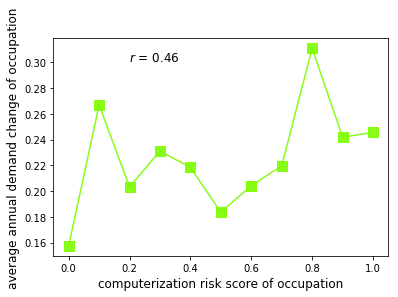

In [38]:
x,y=np.array(sorted([(k,np.mean(v)) for k,v in sncjpc.items()])).T
corr=pearsonr(np.array(x), np.array(y))
if corr[1] < 0.001:
        star = '***'
elif corr[1] >= 0.001 and corr[1] <0.01:
    star = '**'
elif corr[1] >= 0.01 and corr[1] <0.05:
    star = '*'
else:
    star = ''

plt.plot(x,y, marker='s',color='lawngreen',markersize=10,alpha=.9)
plt.figtext(0.3, 0.8, r'$r$' + ' = ' + str(round(corr[0], 2)) + star, fontsize=12)     
plt.xlabel('computerization risk score of occupation', fontsize=12)
plt.ylabel('average annual demand change of occupation', fontsize=12)    
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/corr_cr_demchange.png", bbox_inches='tight')
plt.show()

In [39]:
loc= defaultdict(lambda:defaultdict(lambda:(0,0)))
for job in onagr:
    if job in CR:
        x = onagr[job]
        y = CR[job]
        loc[job] = (x,y)
X,Y=zip(*loc.values())
corr=pearsonr(X,Y)
corr

(0.09642315379520555, 0.012263084568321446)

### computerization risk vs pay change

In [40]:
sncjpc = defaultdict(lambda:[])
for job in CR:
    snc=np.round(CR[job],1)
    if job in opagr and -0.25<opagr[job]<0.4:
        sncjpc[snc].append(opagr[job]) 

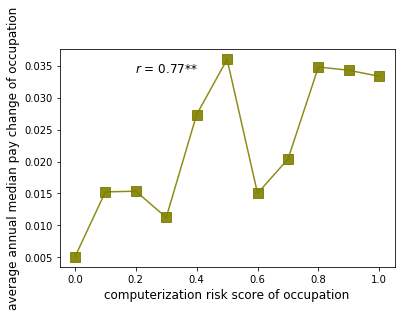

In [41]:
x,y=np.array(sorted([(k,np.mean(v)) for k,v in sncjpc.items()])).T
corr=pearsonr(np.array(x), np.array(y))
if corr[1] < 0.001:
        star = '***'
elif corr[1] >= 0.001 and corr[1] <0.01:
    star = '**'
elif corr[1] >= 0.01 and corr[1] <0.05:
    star = '*'
else:
    star = ''

plt.plot(x,y, marker='s',color='olive',markersize=10,alpha=.9)
plt.figtext(0.3, 0.8, r'$r$' + ' = ' + str(round(corr[0], 2)) + star, fontsize=12)     
plt.xlabel('computerization risk score of occupation', fontsize=12)
plt.ylabel('average annual median pay change of occupation', fontsize=12)    
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/corr_cr_paychange.png", bbox_inches='tight')
plt.show()

In [42]:
loc= defaultdict(lambda:defaultdict(lambda:(0,0)))
for job in opagr:
    if job in CR:
        x = opagr[job]
        y = CR[job]
        loc[job] = (x,y)
X,Y=zip(*loc.values())
corr=pearsonr(X,Y)
corr

(0.22824994470548846, 2.0472440658271507e-09)

## How does job contents transformation?

### Job Transformation in terms of Skill number/complexity

#### Overall Trends

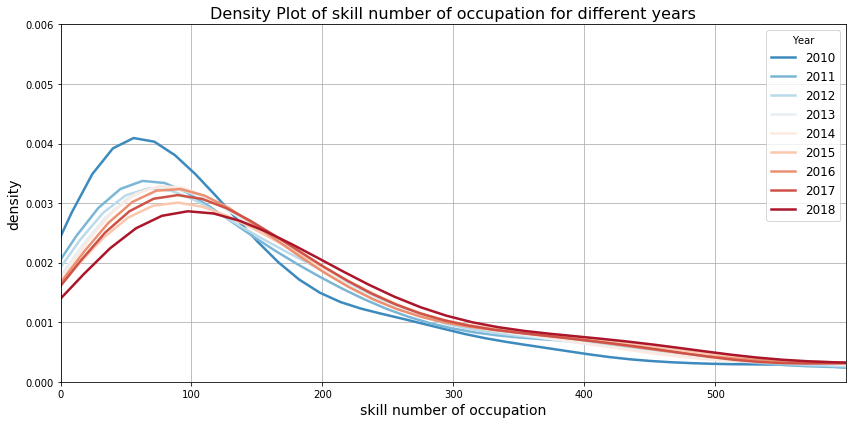

In [45]:
fig = plt.figure(figsize=(12, 6))
plt.xlim(0, 600)
plt.ylim(0, 0.006)
i=0
for year in range(2010,2019):
    i+=1
    sns.distplot(list(yjsn[year].values()), hist=False, kde=True, color=sns.color_palette("RdBu_r", n_colors=10)[i],
                 kde_kws={'linewidth': 2.5}, label=year)
    
plt.xlabel('skill number of occupation', fontsize =14)
plt.ylabel('density', fontsize =14)
plt.title('Density Plot of skill number of occupation for different years', fontsize =16)
plt.legend(prop={'size': 12}, title = 'Year')
plt.xticks(np.arange(0, 600, 100))
plt.grid()
plt.tight_layout()
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/skillnumdensity.png", bbox_inches='tight')

### Please see the rest analyses for job contents transformation in Occupation_Transformation.ipynb, Network_skillparPMI.ipynb, Skill_Mobility.ipynb.

## Do the impacts of new technologies on employment vary between different regions and social groups? 

### Regions

In [146]:
# total number of job openings
size={}
for loc in dic_loc_job_num:
    sum_job = 0
    for job in dic_loc_job_num[loc]:
        sum_job += dic_loc_job_num[loc][job] 
    size[loc] = sum_job

# yearly number of job openings
ysize=dict((i,np.mean([sum(v.values()) for v in dic_loc_year_job_num[i].values()])) for i in dic_loc_year_job_num)

In [148]:
Cscore={}
for loc in dic_loc_job_num:
    if size[loc]>=3:
        jp=defaultdict(lambda:0)
        for j in dic_loc_job_num[loc]:
            jp[j]+=dic_loc_job_num[loc][j]
        s=sum(jp.values())
        jp=dict((k,v/s) for k,v in jp.items())
        c_score=sum([jp[i]*CR[i] for i in jp])
        Cscore[loc]=c_score

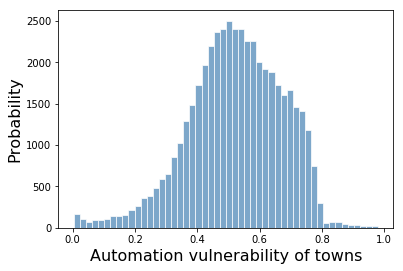

In [149]:
plt.hist(Cscore.values(),50,facecolor='SteelBlue',edgecolor='white',alpha=.7)
plt.xlabel('Automation vulnerability of towns',size=16)
plt.ylabel('Probability',size=16)
plt.show()

In [150]:
threshold=np.percentile(list(Cscore.values()),75)
threshold

0.6332111111111112

In [152]:
#colors=np.array(list(Cscore.values()))
def colorFunction(n):
    if n>threshold:
        return 'red'
    if n<=threshold:
        return 'green'
colors=[colorFunction(i) for i in Cscore.values()]
#
lonR,latR = np.array(list([k for k in Cscore if Cscore[k]>threshold])).T
lonG,latG = np.array(list([k for k in Cscore if Cscore[k]<=threshold])).T
#
ykR=[ysize[k] for k in Cscore if Cscore[k]>threshold]
ykG=[ysize[k] for k in Cscore if Cscore[k]<=threshold]

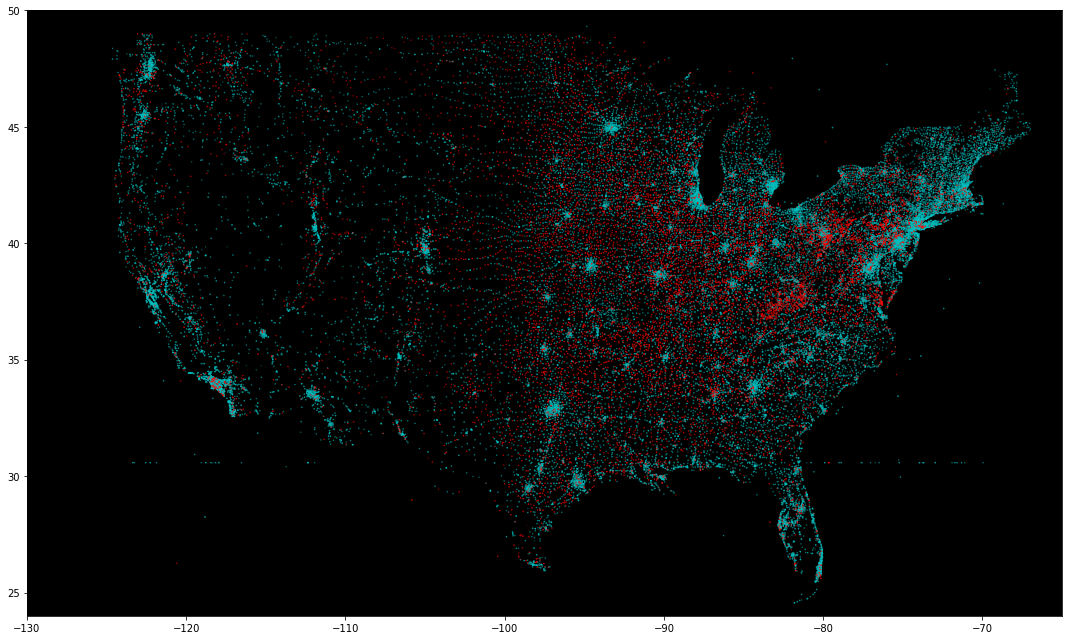

In [19]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
plt.scatter(lonG,latG,s=np.log(ykG)/15,c='c',alpha=.7)
plt.scatter(lonR,latR,s=np.log(ykR)/15,c='r',alpha=.9)
plt.xlim(-130,-65)
plt.ylim(24,50)
ax.set_facecolor('black')
plt.tight_layout()
plt.savefig('/Users/ditong/Documents/skillProject/description/vis/map.pdf')
plt.show()

### Small towns are more vulnerable to automation

In [153]:
sizedata,cscore=np.array([(size[i],Cscore[i]) for i in Cscore]).T
ysizedata,cscore=np.array([(ysize[i],Cscore[i]) for i in Cscore]).T

In [154]:
pearsonr(sizedata,cscore)

(-0.07325664636721096, 1.7977225300463065e-57)

In [155]:
pearsonr(ysizedata,cscore)

(-0.07594845087530744, 1.196265221623658e-61)

In [156]:
pearsonr(np.log(ysizedata),cscore)

(-0.12210510916147298, 5.003856214038879e-157)

In [157]:
max(ykR),max(ykG)

(1615.8, 265755.8)

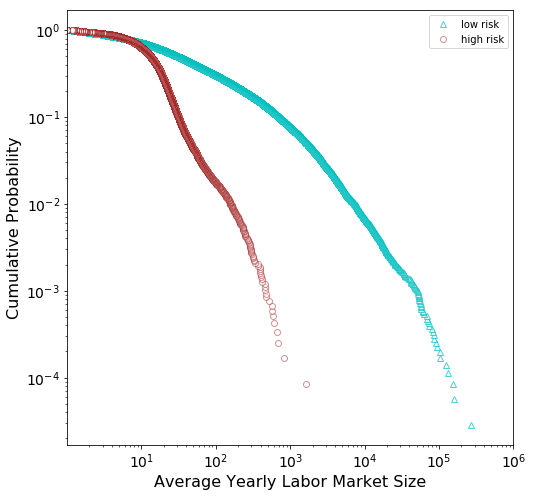

In [158]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
#Zipf plot
plt.plot(sorted(ykG,reverse=True),np.array(range(1,len(ykG)+1))/(len(ykG)+1),
         marker='^',linestyle='',markeredgecolor='c',
         markerfacecolor='white',alpha=.7, label='low risk')
plt.plot(sorted(ykR,reverse=True),np.array(range(1,len(ykR)+1))/(len(ykR)+1),
         marker='o',linestyle='',markeredgecolor='brown',
         markerfacecolor='white',alpha=.5, label='high risk')
plt.xscale('log')
plt.yscale('log')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Average Yearly Labor Market Size',fontsize=16)
plt.ylabel('Cumulative Probability',fontsize=16)
plt.xticks([10,10**2,10**3,10**4,10**5,10**6,10**7])
plt.xlim(1,10**6)
plt.legend()
plt.savefig('/Users/ditong/Documents/skillProject/description/vis/small_town_more_vulnerable.pdf')
plt.show()

### Political Implications

In [159]:
state_risk={}
for state in dic_year_state_job_num['2016']:
    jp=defaultdict(lambda:0)
    for job in dic_year_state_job_num['2016'][state]:
        jp[job]+=int(dic_year_state_job_num['2016'][state][job])
    s=sum(jp.values())
    jp=dict((k,v/s) for k,v in jp.items())
    c_score=sum([jp[i]*CR[i] for i in jp])
    state_risk[state]=c_score

sorted_state_risk = sorted(state_risk.items(), key=operator.itemgetter(1),reverse=True)
df_state_risk = pd.DataFrame(columns = ["State", "computerization risk score"])
data_ind, data_risk = zip(*sorted_state_risk)
df_state_risk["State"] = list(data_ind)
df_state_risk["computerization risk score"] = list(data_risk)

In [160]:
df_merged = pd.merge(df_state_risk, df_vote, how='left', on=['State'])
pearsonr(np.array(df_merged['computerization risk score']), np.array(df_merged['votePctRep']))

(0.7134670524171735, 6.065537167667048e-09)

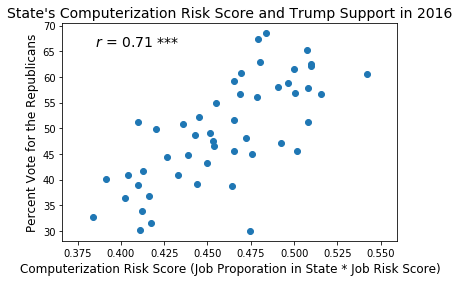

In [163]:
plt.figure(figsize=(6,4))
plt.scatter(np.array(df_merged['computerization risk score']), np.array(df_merged['votePctRep']))
plt.figtext(0.2, 0.8, r'$r$' + ' = 0.71 ***',fontsize=14)
plt.title("State's Computerization Risk Score and Trump Support in 2016", fontsize=14)
plt.xlabel('Computerization Risk Score (Job Proporation in State * Job Risk Score)', fontsize=12)
plt.ylabel('Percent Vote for the Republicans', fontsize=12)
plt.savefig('/Users/ditong/Documents/skillProject/description/vis/vote_csrisk.png')

### Social Groups

In [164]:
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [165]:
# construct the function to tokenize skills in order to match them to the uni-grams in the Google News corpus
def tokenizeword(s):
    '''
    Tokenize a word, delete all "()", ",", "/" and "&" and make it lowercased.
    
    Input:
        s: a word (str)
    '''
    s=s.lower()
    s = s.replace('(',' ').replace(')',' ').replace('/',' ').replace('&',' ').replace(
        ',',' ').replace('-', ' ').replace("’s", ' ').replace("–", " ").replace("#", " ")
    tokens = [t for t in s.split() if t not in stopwords]
    s=" ".join(tokens)

    return s

In [166]:
# calculate the average google vector representation for each job, store in a dictionary J
j={}
for job in CR:
    tj=tokenizeword(job)
    tokens=tj.split()
    vt = [i for i in tokens if i in model]
    if len(vt)==len(tokens):
        vs=np.mean([model[s] for s in vt],axis=0)
        j[job]=vs
    else:
        print(job, tj, vt)
        
# check how many jobs can be matched to the google news corpus
len(j), len(CR)

Foundry Mold and Coremakers foundry mold coremakers ['foundry', 'mold']
Food Batchmakers food batchmakers ['food']
Petroleum Pump System Operators, Refinery Operators, and Gaugers petroleum pump system operators refinery operators gaugers ['petroleum', 'pump', 'system', 'operators', 'refinery', 'operators']
Refractory Materials Repairers, Except Brickmasons refractory materials repairers except brickmasons ['refractory', 'materials', 'repairers', 'except']
Brickmasons and Blockmasons brickmasons blockmasons []
Railroad Conductors and Yardmasters railroad conductors yardmasters ['railroad', 'conductors']
Helpers–Brickmasons, Blockmasons, Stonemasons, and Tile and Marble Setters helpers brickmasons blockmasons stonemasons tile marble setters ['helpers', 'stonemasons', 'tile', 'marble', 'setters']
Food Servers, Nonrestaurant food servers nonrestaurant ['food', 'servers']
Paperhangers paperhangers []
Cartographers and Photogrammetrists cartographers photogrammetrists ['cartographers']
Rail

(687, 702)

In [167]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector
def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff
def makeDF(dic_job, word_list, df, colname, dimension):
    projection = []
    for word in word_list:
        #print(word)
        #print(dic_job[word].reshape(1,-1))
        #print(dimension.reshape(1,-1))
        #print(sklearn.metrics.pairwise.cosine_similarity(dic_job[word].reshape(1,-1), dimension.reshape(1,-1)))
        #print(sklearn.metrics.pairwise.cosine_similarity(dic_job[word].reshape(1,-1), dimension.reshape(1,-1))[0][0])
        projection.append(sklearn.metrics.pairwise.cosine_similarity(dic_job[word].reshape(1,-1), dimension.reshape(1,-1))[0][0])
    df[colname] = projection

    return df
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()+0.02
    MinY = df[dim].min()-0.02
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

#### Gender

In [168]:
# construct the masculine dimension
masculinity = dimension(model, ['man','men','him','he', 'his', 'his', 'boy', 'boys', 'male', 'masculine'], 
                   ['woman', 'women','her', 'she', 'her', 'hers', 'girl', 'girls', 'female', 'feminine'])

# project all skills onto the masculine dimension, store the projection value (cos similarity) in a dictionary gender
df_projections = pd.DataFrame(index = list(j.keys()))
df_projections = makeDF(j, list(df_projections.index), df_projections, 'gender', masculinity)
df_projections['risk'] = [CR[job] for job in list(df_projections.index)]
df_projections = df_projections.sort_values(by=['gender'])

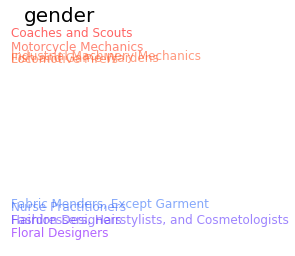

In [171]:
df_gender= pd.DataFrame({})
df_gender['gender'] = df_projections['gender'][:5].append(df_projections['gender'][-5:])
fig = plt.figure(figsize = (6,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, df_gender, 'gender')

In [172]:
df_gender

,gender
Floral Designers,-0.278013
"Hairdressers, Hairstylists, and Cosmetologists",-0.247575
Fashion Designers,-0.247398
Nurse Practitioners,-0.218113
"Fabric Menders, Except Garment",-0.211747
Locomotive Firers,0.119841
Fish and Game Wardens,0.122623
Industrial Machinery Mechanics,0.126557
Motorcycle Mechanics,0.147462
Coaches and Scouts,0.179711


In [169]:
pearsonr(df_projections['risk'],df_projections['gender'])

(0.12577970566201957, 0.0009535035641952756)

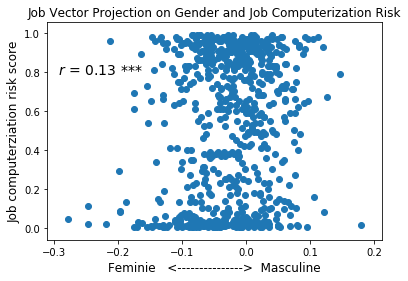

In [181]:
plt.figure(figsize=(6,4))
plt.scatter(df_projections['gender'], df_projections['risk'])
plt.figtext(0.15, 0.7, r'$r$' + ' = 0.13 ***',fontsize=14)
plt.title('Job Vector Projection on Gender and Job Computerization Risk')
plt.xlabel('Feminie   <--------------->  Masculine', fontsize=12)
plt.ylabel('Job computerziation risk score', fontsize=12)
plt.savefig('/Users/ditong/Documents/skillProject/description/vis/gender_csrisk.png')

#### Race

In [173]:
# construct the black dimension
black = dimension(model, ['black','blacks','Blacks','Black', 'African', 'African', 'Afro'], 
                   ['white', 'whites', 'Whites',  'White', 'European', 'Caucasian','Anglo'])

# project all skills onto the masculine dimension, store the projection value (cos similarity) in a dictionary gender
df_projections = makeDF(j, list(df_projections.index), df_projections, 'race', black)
df_projections = df_projections.sort_values(by=['race'])

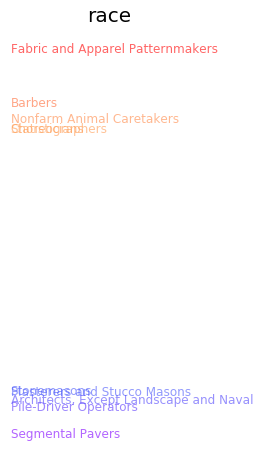

In [174]:
df_race= pd.DataFrame({})
df_race['race'] = df_projections['race'][:5].append(df_projections['race'][-5:])
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, df_race, 'race')

In [175]:
df_race

,race
Segmental Pavers,-0.141821
Pile-Driver Operators,-0.119737
"Architects, Except Landscape and Naval",-0.113953
Plasterers and Stucco Masons,-0.107938
Stonemasons,-0.107063
Statisticians,0.103229
Choreographers,0.103364
Nonfarm Animal Caretakers,0.111647
Barbers,0.124635
Fabric and Apparel Patternmakers,0.167793


In [176]:
pearsonr(df_projections['risk'],df_projections['race'])

(-0.10775887963411955, 0.004690892373758769)

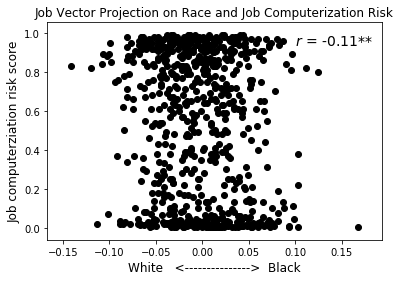

In [182]:
plt.figure(figsize=(6,4))
plt.scatter(df_projections['race'], df_projections['risk'],color='black')
plt.figtext(0.7, 0.8, r'$r$' + ' = -0.11**',fontsize=14)
plt.title('Job Vector Projection on Race and Job Computerization Risk')
plt.xlabel('White   <--------------->  Black', fontsize=12)
plt.ylabel('Job computerziation risk score', fontsize=12)
plt.savefig('/Users/ditong/Documents/skillProject/description/vis/race_csrisk.png')

#### Immigration Status

In [183]:
#construct the immigrant dimension
immigrant = dimension(model, ['immigrant','immigrants','emigrant','emigrants','migrant', 'migrants',
                'alien', 'foreigner', 'foreigners'], ['native', 'natives',  'citizen',  'citizens', 'local', 'locals',
                 'resident','national', 'nationals'])


# project all skills onto the masculine dimension, store the projection value (cos similarity) in a dictionary gender
df_projections = makeDF(j, list(df_projections.index), df_projections, 'immigrant', immigrant)
df_projections = df_projections.sort_values(by=['immigrant'])

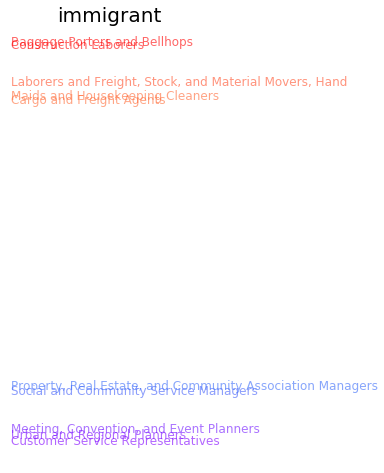

In [184]:
df_immigrant= pd.DataFrame({})
df_immigrant['immigrant'] = df_projections['immigrant'][:5].append(df_projections['immigrant'][-5:])
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, df_immigrant, 'immigrant')

In [185]:
df_immigrant

,immigrant
Customer Service Representatives,-0.206944
Urban and Regional Planners,-0.201020
"Meeting, Convention, and Event Planners",-0.194379
Social and Community Service Managers,-0.152441
"Property, Real Estate, and Community Association Managers",-0.146570
Cargo and Freight Agents,0.167297
Maids and Housekeeping Cleaners,0.171102
"Laborers and Freight, Stock, and Material Movers, Hand",0.187325
Construction Laborers,0.227546
Baggage Porters and Bellhops,0.230410


In [186]:
pearsonr(df_projections['risk'],df_projections['immigrant'])

(0.20236519352901194, 8.799357842050892e-08)

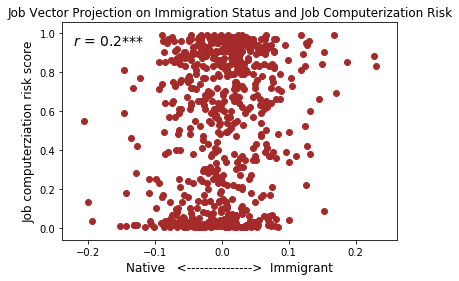

In [188]:
plt.figure(figsize=(6,4))
plt.scatter(df_projections['immigrant'], df_projections['risk'],color="brown")
plt.figtext(0.15, 0.8, r'$r$' + ' = 0.2***',fontsize=14)
plt.title('Job Vector Projection on Immigration Status and Job Computerization Risk')
plt.xlabel('Native   <--------------->  Immigrant', fontsize=12)
plt.ylabel('Job computerziation risk score', fontsize=12)
plt.savefig('/Users/ditong/Documents/skillProject/description/vis/immig_csrisk.png')